# Bayes-by-backprop
## 1D regression

In [1]:
import jax
import optax
import distrax
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from chex import dataclass
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from jaxtyping import Float, Array
from flax.training.train_state import TrainState

from dynamax.utils import datasets
from dynamax.rebayes import bayes_by_backprop as bbb

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

## Load dataset

In [3]:
train, test = datasets.load_1d_synthetic_dataset(200, 400)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

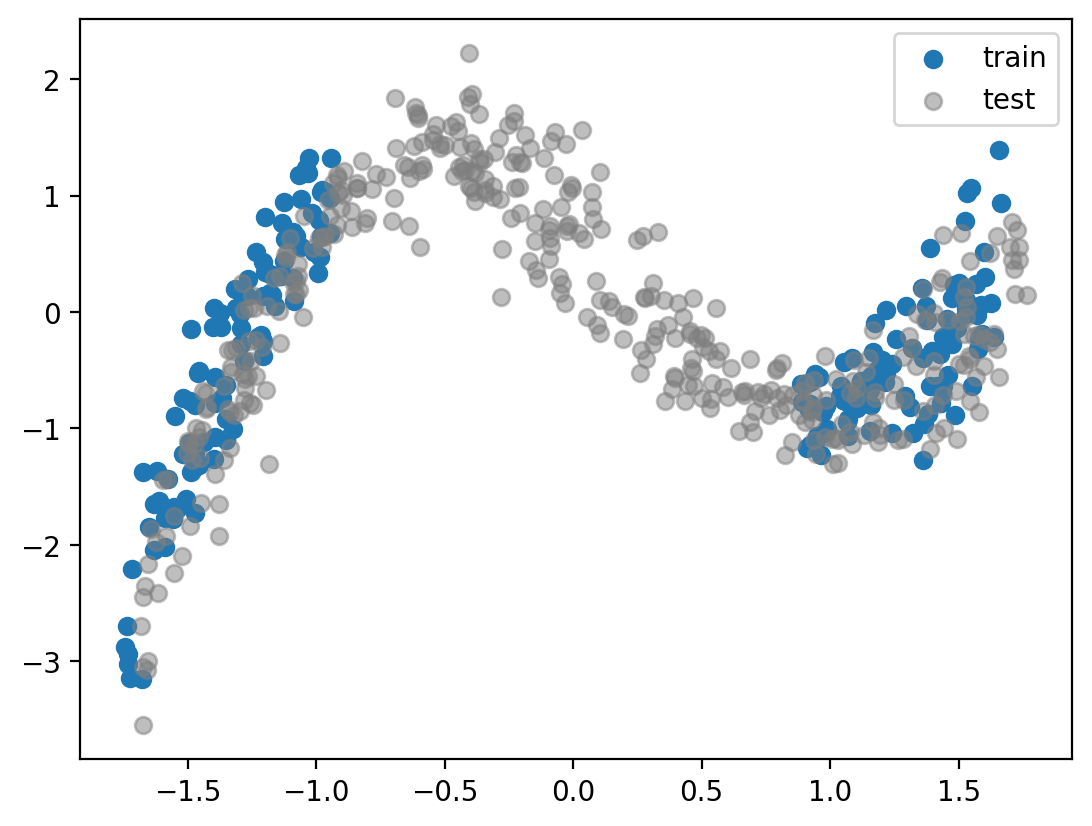

In [4]:
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, c="tab:gray", label="test", alpha=0.5, )
plt.legend()

In [7]:
def sample_gp(seed=None):
    """
    Taken from
    https://github.com/JavierAntoran/Bayesian-Neural-Networks
    """
    ...

In [ ]:
import GPy
np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)


k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())

ixs = np.random.choice(no_points, no_points, replace=False)
x = x[ixs]
y = y[ixs]


X_train = x[:200]
y_train = y[:200]

X_test = x[200:]
y_test = y[200:]

x_mean, x_std = X_train.mean(), X_train.std()
y_mean, y_std = y_train.mean(), y_train.std()

X_train = (X_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std

X_test = (X_test - x_mean) / x_std
y_test = (y_test - y_mean) / y_std

X_train = jnp.array(X_train)
y_train = jnp.array(y_train).ravel()

X_test = jnp.array(X_test)
y_test = jnp.array(y_test).ravel()

xmap = ((X_train > -0.5) & (X_train < 0.5)).ravel()
X_train = X_train[~xmap]
y_train = y_train[~xmap]


plt.scatter(X_train, y_train, label="train")
plt.scatter(X_test, y_test, alpha=0.5, label="test")
plt.legend()
plt.grid(alpha=0.5)

### Linked

In [5]:
@dataclass
class PriorParam:
    scale_obs: float
    scale_weight: float

def cost_fn(
    key: jax.random.PRNGKey,
    state: bbb.BBBParams,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam,
    rbnn_scale: float
):
    """
    TODO:
    * Add more general way to compute observation-model log-probability
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    # Sampled params
    params = bbb.sample_rbnn_params(key, state, reconstruct_fn, scale=rbnn_scale)
    # params = bbb.sample_gauss_params(key, state, reconstruct_fn)
    params_flat = bbb.get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()

    # Variational log-probability
    logp_variational = jax.tree_map(
        lambda mean, rho, x: distrax.Normal(loc=mean, scale=jnp.log(1 + jnp.exp(rho))).log_prob(x),
        state.mean, state.rho, params
    )
    logp_variational = bbb.get_leaves(logp_variational).sum()
    
    num_obs = len(y)
    loss = (logp_variational - logp_prior) - logp_obs
    return loss


def lossfn(key, params, X, y, model, reconstruct_fn, priors, rbnn_scale, num_samples=30):
    # TODO: add costfn as input
    keys = jax.random.split(key, num_samples)
    cost_vmap = jax.vmap(cost_fn, in_axes=(0, None, None, None, None, None, None, None))
    loss = cost_vmap(keys, params, X, y, reconstruct_fn, model, priors, rbnn_scale).mean()
    return loss


@partial(jax.jit, static_argnames=("reconstruct_fn", "rbnn_scale"))
@partial(jax.vmap, in_axes=(0, None, None, None, None))
def sample_and_eval(key, state, X, reconstruct_fn, rbnn_scale):
    params_sample = bbb.sample_rbnn_params(key, state, reconstruct_fn, scale=rbnn_scale)
    # params_sample = bbb.sample_gauss_params(key, state, reconstruct_fn)
    return model.apply(params_sample, X)


@partial(jax.jit, static_argnames=("reconstruct_fn", "rbnn_scale", "num_samples"))
def eval_mae(key, params, X, y, reconstruct_fn, rbnn_scale, num_samples=20):
    keys_sample = jax.random.split(key, num_samples)
    yhat_samples = sample_and_eval(keys_sample, params, X, reconstruct_fn, rbnn_scale).squeeze()
    yhat = yhat_samples.mean(axis=0)
    err_pp = y - yhat
    return jnp.abs(err_pp).mean(), yhat

## Model setup

In [6]:
class MLP(nn.Module):
    dim_out: int
    dim_hidden: int = 100
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(100)(x)
        x = self.activation(x)
        x = nn.Dense(50)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(10)(x)
        x = self.activation(x)
        x = nn.Dense(self.dim_out)(x)
        return x

In [7]:
key = jax.random.PRNGKey(314)
key_init, key_train = jax.random.split(key)

In [8]:
dim_input = 1
batch_size = 100
batch = (batch_size, dim_input)
model = MLP(1, dim_hidden=200, activation=nn.elu)
batch = jnp.ones(batch)

In [9]:
from jax.flatten_util import ravel_pytree
def init_bbb_params(key, model, batch_init):
    key_mean, key_rho, key_r = jax.random.split(key, 3)
    
    params_mean = model.init(key_mean, batch_init)
    flat_params, reconstruct_fn = ravel_pytree(params_mean)
    num_params = len(flat_params)
        
    params_rho = jax.random.uniform(key_rho, (num_params,), minval=2, maxval=2)
    params_rho = reconstruct_fn(params_rho)
    
    bbb_params = bbb.BBBParams(
        mean=params_mean,
        rho=params_rho,
    )
    
    return bbb_params, (reconstruct_fn, num_params)

Text(0.5, 1.0, 'BNN Gauss — prior samples')

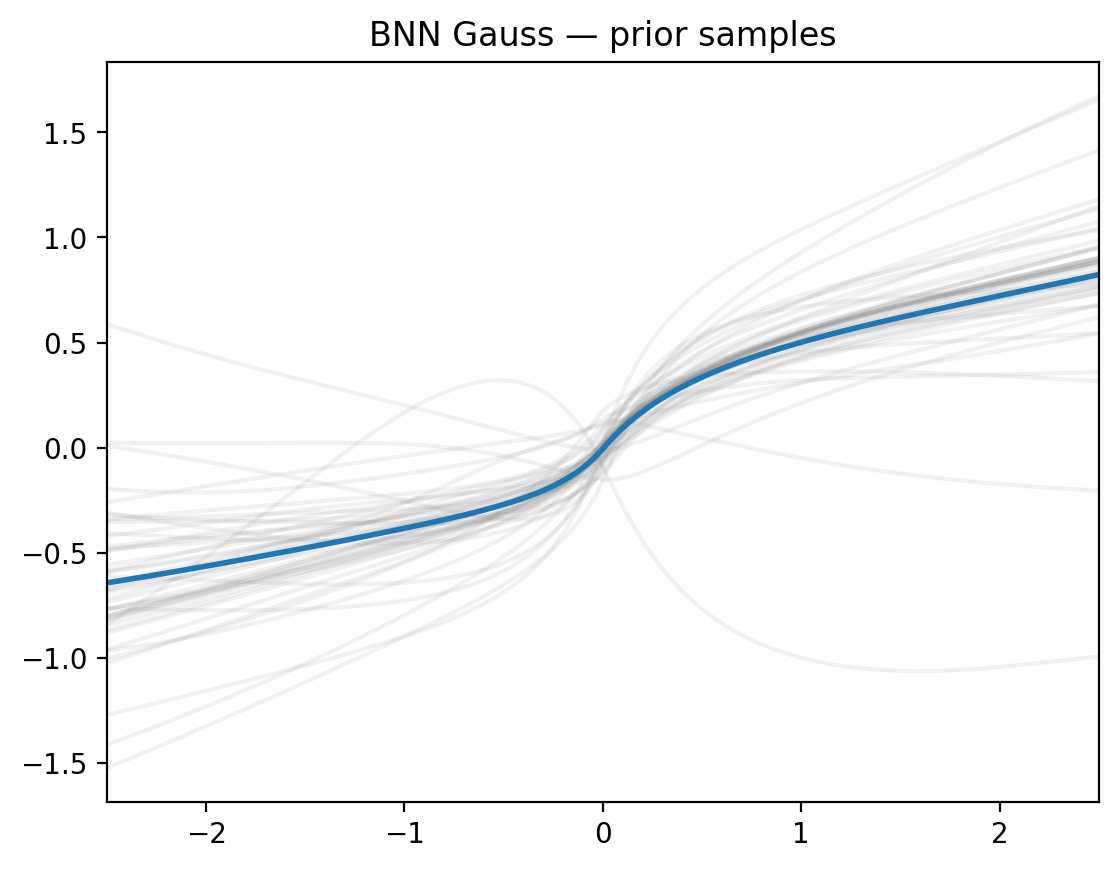

In [10]:
# Sample initial parameters
rbnn_scale = 1.0
priors = PriorParam(scale_obs=1.0, scale_weight=1.0)
part_lossfn = partial(lossfn, priors=priors, rbnn_scale=rbnn_scale)

# Bayes-by-backprop params
b3p, (reconstruct_fn, num_params) = init_bbb_params(key_init, model, batch)

xmin, xmax = -2.5, 2.5
x_eval = jnp.linspace(xmin, xmax, 200)
keys_eval = jax.random.split(key_train, 50)
yhat_prior = sample_and_eval(keys_eval, b3p, x_eval[:, None], reconstruct_fn, rbnn_scale).squeeze()

yhat_prior_mean = yhat_prior.mean(axis=0)
yhat_prior_std = yhat_prior.std(axis=0)

for sample in yhat_prior:
    plt.plot(x_eval, sample, c="tab:gray", alpha=0.1)
plt.plot(x_eval, yhat_prior_mean, c="tab:blue", linewidth=2)
plt.xlim(xmin, xmax)


plt.title("BNN Gauss — prior samples")

In [11]:
%%time

num_epochs = 3000
tx = optax.adam(5e-4)

opt_state = TrainState.create(
    apply_fn=model.apply,
    params=b3p,
    tx=tx
)


losses = []
test_mae = []
train_mae = []

for epoch in (pbar := tqdm(range(num_epochs))):
    key_epoch = jax.random.fold_in(key_train, epoch)
    loss, opt_state = bbb.train_epoch(key_epoch, opt_state, X_train, y_train, batch_size, part_lossfn, model, reconstruct_fn)
    
    mae_train, _ = eval_mae(key, opt_state.params, X_train, y_train, reconstruct_fn, rbnn_scale)
    mae_test, _ =  eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn, rbnn_scale)
    test_mae.append(mae_test)
    train_mae.append(mae_train)

    
    pbar.set_description(f"{loss=:0.4e} | {mae_train=:0.4f} | {mae_test=:0.4f}")
    losses.append(loss)
    
losses = np.array(losses)
test_mae = np.array(test_mae)
train_mae = np.array(train_mae)

  0%|          | 0/3000 [00:00<?, ?it/s]

CPU times: user 39.1 s, sys: 7.37 s, total: 46.5 s
Wall time: 25.7 s


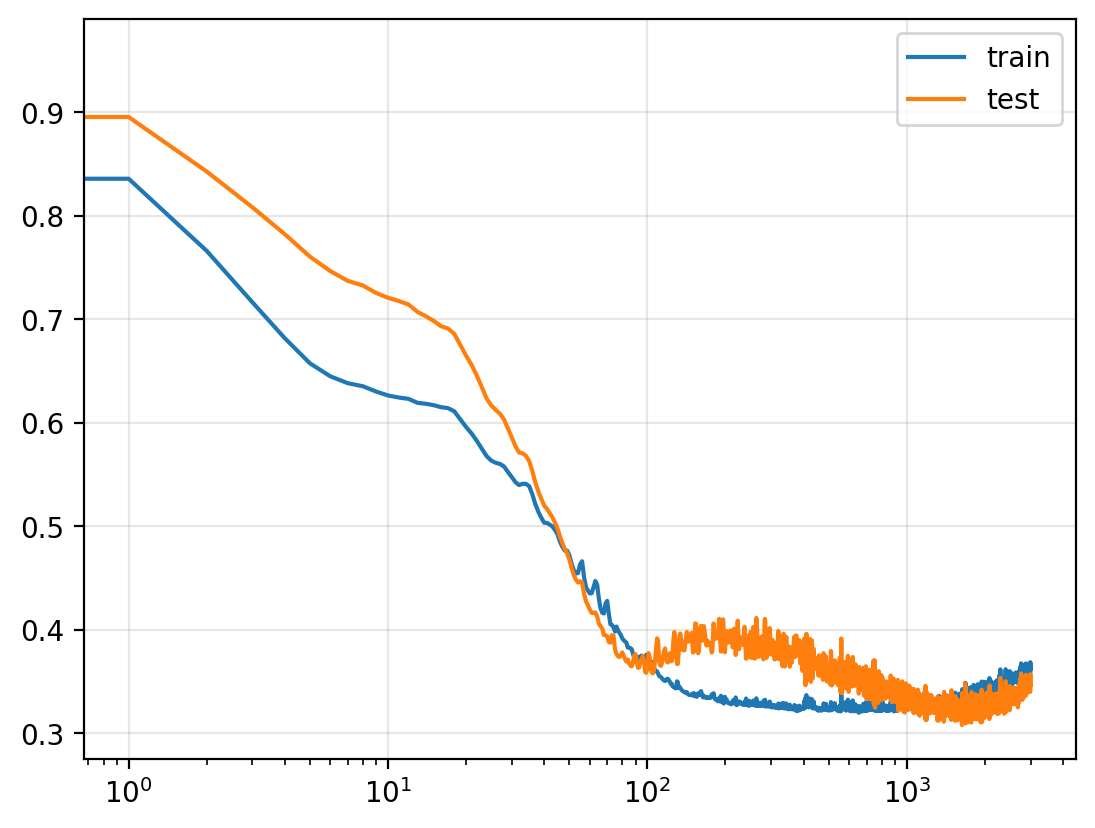

In [12]:
plt.plot(train_mae, label="train")
plt.plot(test_mae, label="test")
plt.legend()
plt.xscale("log")
plt.grid(alpha=0.3)

## Model evaluation

In [13]:
mae, yhat_test = eval_mae(key, opt_state.params, X_test, y_test, reconstruct_fn, rbnn_scale, num_samples=20)
mae

Array(0.3464903, dtype=float32)

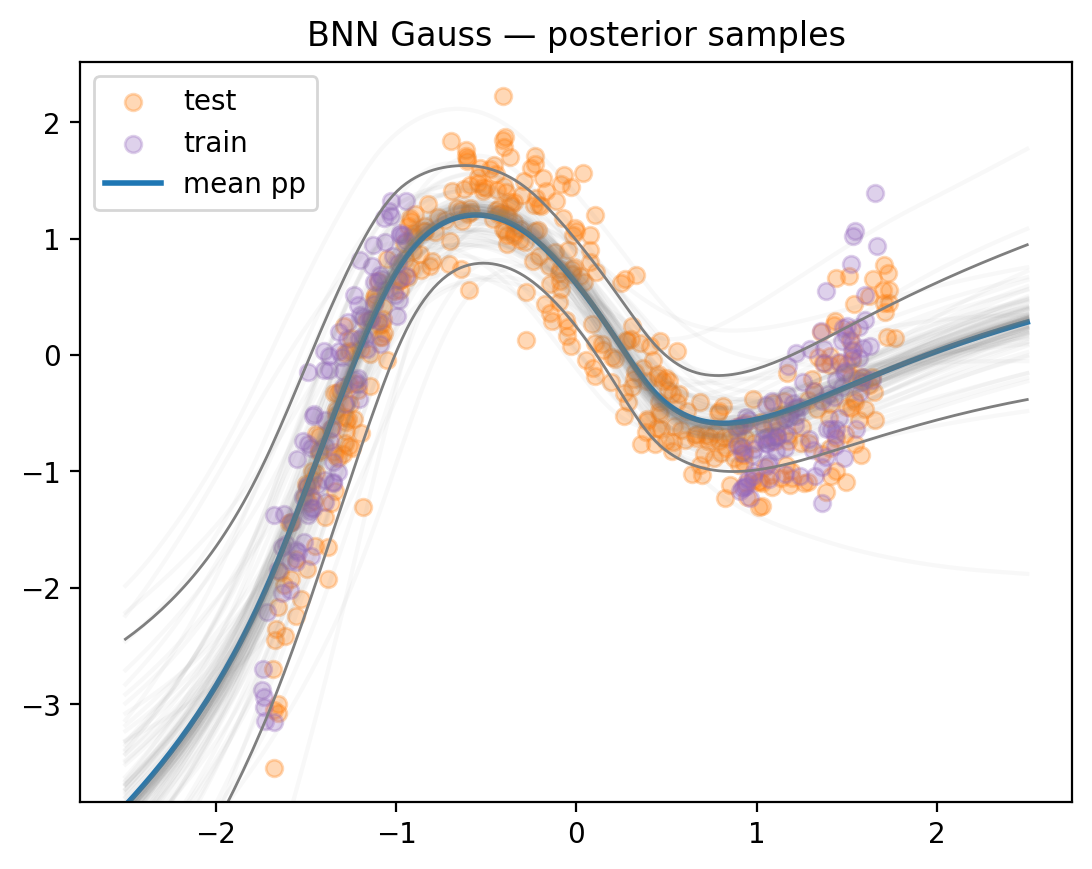

In [14]:
x_eval = jnp.linspace(-2.5, 2.5, 200)
keys_eval = jax.random.split(key_train, 100)
yhat_samples = sample_and_eval(keys_eval, opt_state.params, x_eval[:, None], reconstruct_fn, rbnn_scale).squeeze()

yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

plt.scatter(X_test, y_test, alpha=0.3, c="tab:orange", label="test")
plt.scatter(X_train, y_train, alpha=0.3, c="tab:purple", label="train")
ymin, ymax = plt.ylim()

plt.plot(x_eval, yhat_mean, c="tab:blue", linewidth=2, label="mean pp")
plt.plot(x_eval, yhat_mean + 2 * yhat_std, c="tab:gray", linewidth=1)
plt.plot(x_eval, yhat_mean - 2 * yhat_std, c="tab:gray", linewidth=1)


for sample in yhat_samples:
    plt.plot(x_eval, sample, c="tab:gray", alpha=0.05)
plt.ylim(ymin, ymax)

plt.legend()
plt.title("BNN Gauss — posterior samples");

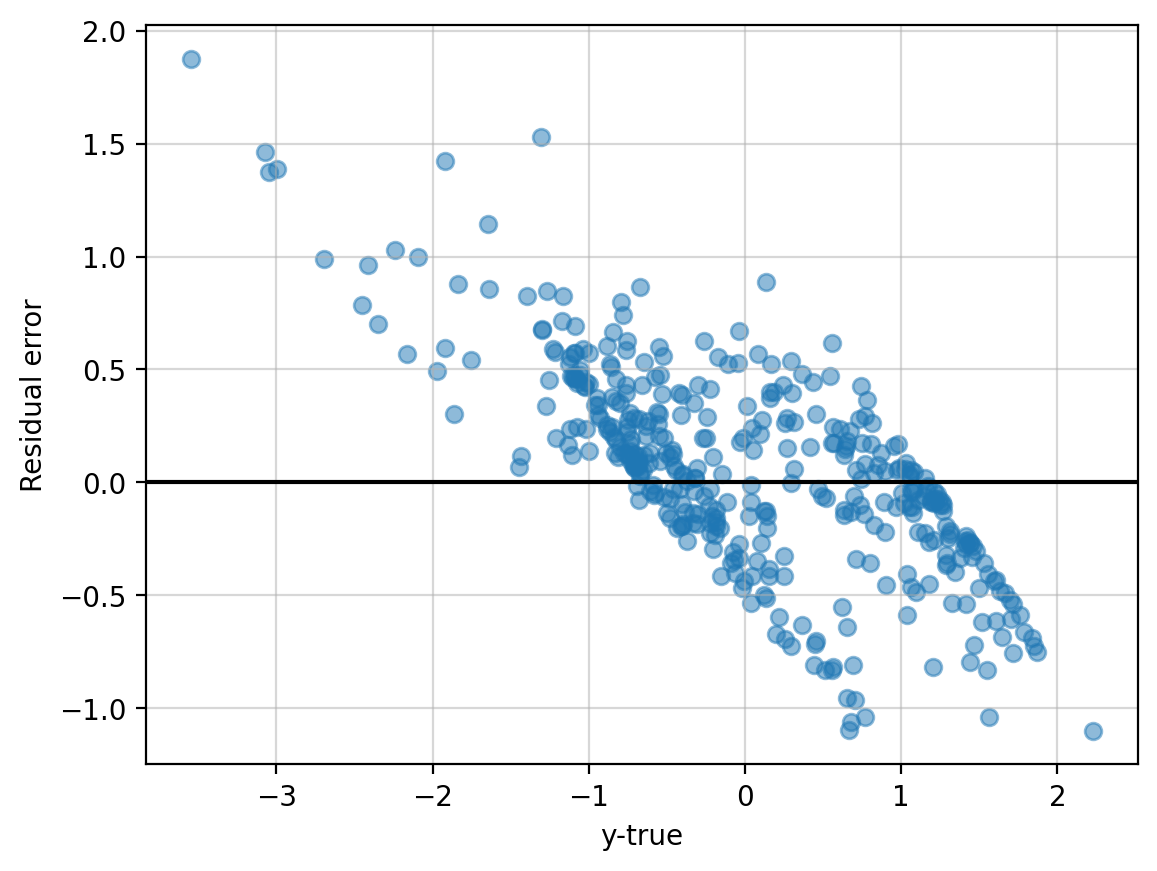

In [15]:
residual_err = yhat_test - y_test
plt.scatter(y_test, residual_err, alpha=0.5, edgecolors=None)
plt.ylabel("Residual error")
plt.xlabel("y-true")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.5)

# HMC

In [16]:
import blackjax

In [41]:
def log_joint(
    params: nn.FrozenDict,
    X: Float[Array, "num_obs dim_obs"],
    y: Float[Array, "num_obs"],
    reconstruct_fn: Callable,
    model: nn.Module,
    priors: PriorParam,
    rbnn_scale: float
):
    """
    TODO:
    * Add more general way to compute observation-model log-probability
    """
    scale_obs = priors.scale_obs
    scale_prior = priors.scale_weight
    
    params_flat = bbb.get_leaves(params)
    
    # Prior log probability (use initialised vals for mean?)
    logp_prior = distrax.Normal(loc=0.0, scale=scale_prior).log_prob(params_flat).sum()
    
    # Observation log-probability
    mu_obs = model.apply(params, X).ravel()
    logp_obs = distrax.Normal(loc=mu_obs, scale=scale_obs).log_prob(y).sum()
    
    logprob = logp_prior + logp_obs
    return logprob


In [42]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states


In [43]:
params_init = model.init(key_init, batch)

In [44]:
# Sample initial parameters
rbnn_scale = 1.0
priors = PriorParam(scale_obs=1.0, scale_weight=1.0)
potential = partial(log_joint,
                    priors=priors, rbnn_scale=rbnn_scale, X=X_train, y=y_train,
                    reconstruct_fn=reconstruct_fn, model=model)

In [ ]:
%%time
num_samples = 50
num_warmup = 500
num_steps = 100


adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_init, params_init)
states = inference_loop(key_train, kernel, final_state, num_steps)

sampled_params = jax.block_until_ready(states.position)

(-3.835890996456146, 2.515101897716522)

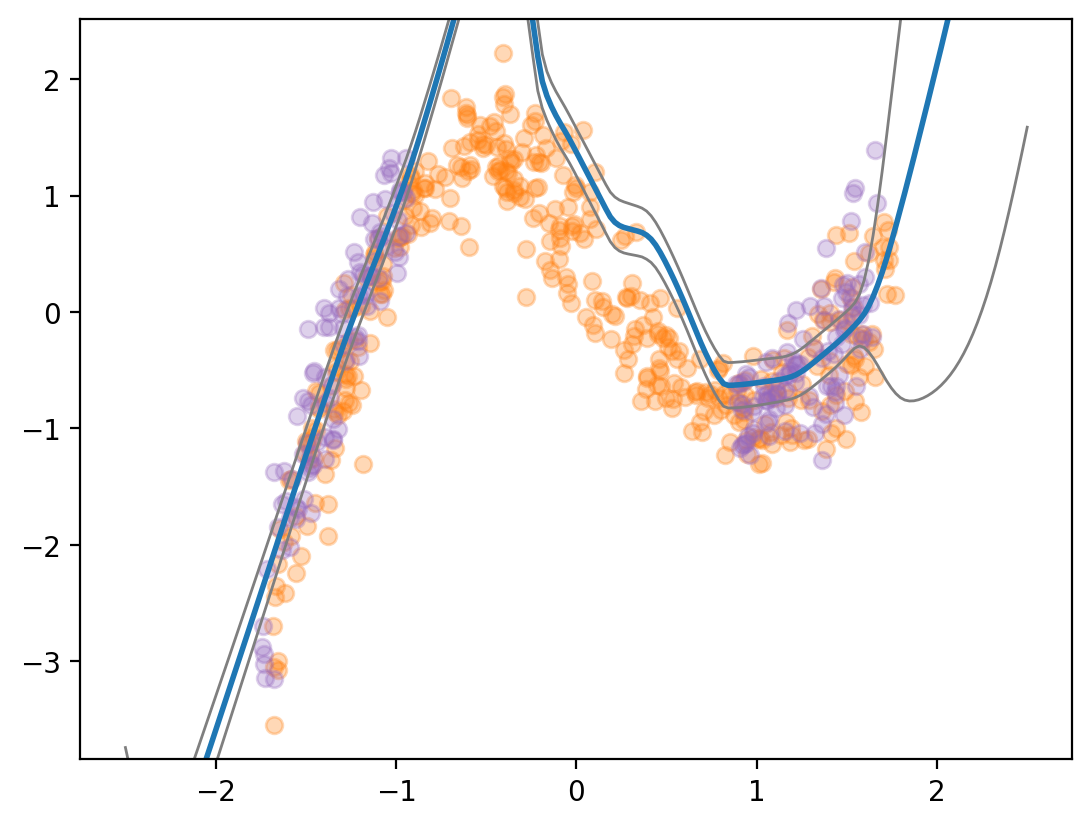

In [46]:
yhat_samples = jax.vmap(model.apply, (0, None))(sampled_params, x_eval[:, None]).squeeze()

yhat_mean = yhat_samples.mean(axis=0)
yhat_std = yhat_samples.std(axis=0)

plt.scatter(X_test, y_test, alpha=0.3, c="tab:orange", label="test")
plt.scatter(X_train, y_train, alpha=0.3, c="tab:purple", label="train")
ymin, ymax = plt.ylim()

plt.plot(x_eval, yhat_mean, c="tab:blue", linewidth=2, label="mean pp")
plt.plot(x_eval, yhat_mean + 2 * yhat_std, c="tab:gray", linewidth=1)
plt.plot(x_eval, yhat_mean - 2 * yhat_std, c="tab:gray", linewidth=1)


# for sample in yhat_samples:
#     plt.plot(x_eval, sample, c="tab:gray", alpha=0.05)
plt.ylim(ymin, ymax)


In [ ]:
model.apply(params_init, x_eval[:, None])

In [ ]:
jax.vmap(model.apply, (0, None))

In [32]:
jax.tree_map(jnp.shape, sampled_params)

FrozenDict({
    params: {
        Dense_0: {
            bias: (500, 100),
            kernel: (500, 1, 100),
        },
        Dense_1: {
            bias: (500, 50),
            kernel: (500, 100, 50),
        },
        Dense_2: {
            bias: (500, 10),
            kernel: (500, 50, 10),
        },
        Dense_3: {
            bias: (500, 10),
            kernel: (500, 10, 10),
        },
        Dense_4: {
            bias: (500, 1),
            kernel: (500, 10, 1),
        },
    },
})

In [29]:
x_eval.shape

(200,)